# merging and cleaning processed paediatric Visium data - post cell2location deconvolution

In [4]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import re
import os
import scipy.stats
from numpy import asarray as ar
from collections import Counter
import scvi
import anndata as ad
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

from datetime import date
today = str(date.today())
sc.settings.verbosity = 1
sc.logging.print_version_and_date()
%load_ext autoreload
%autoreload 2

Running Scanpy 1.9.1, on 2023-07-23 16:32.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
## For correct plotting of the images
import matplotlib
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')

In [6]:
# output folder 
import os
os.getcwd()

'/nfs/team205/ny1/ThymusSpatialAtlas/Figure2'

# Orgenize analysis object 
this is divided to 4 steps:
1) load cell2loaction object "sp" which has only HVG genes 
2) load merged raw visium object "adata_vis" 
3) create a new object with all annotations and all raw genes
4) update tissue tag annotations from to generate a final annotated object 

In [8]:
# load c2l object 
adata_paed = sc.read('/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_anno_v9_paed_sub_15K/cell2location_map/sp.h5ad')
adata_paed

AnnData object with n_obs × n_vars = 35764 × 15000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'L2_dist_Annotation_lv_0_Artifacts', 'Annotation_lv_0', 'L2_dist_Annotation_lv_0_Background', 'L2_dist_Annotation_lv_0_Cortex', 'L2_dist_Annotation_lv_0_Edge', 'L2_dist_Annotation_lv_0_Medulla', 'L2_dist_log10_Annotation_lv_1_HS', 'Annotation_lv_1', 'L2_dist_log10_Annotation_lv_1_Lymph', 'L2_dist_log10_Annotation_lv_1_PVS', 'L2_dist_log10_Annotation_lv_1_Unassigned', 'Annotation_lobules', 'Cortico_Medullar_Axis', 'SampleID', 'L2_dist_Annotation_lv_0_Unassigned', 'Annotation_lobules_0', 'Annotation_lobules_1', 'L2_dist_log10_Annotation_lv_1_Fat', 'Leiden_0_5', 'L2_dist_log10_Annotation_lv_1_Large vessel', 'Sample ', 'Sample_hr', 'SlideID', 'Position', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN

In [9]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_paed.obs[adata_paed.uns['mod']['factor_names']] = adata_paed.obsm['q05_cell_abundance_w_sf']
adata_paed.obs['tot_cell_abundance'] = adata_paed.uns["mod"]["post_sample_means"]["w_sf"].sum(1).flatten()
adata_paed.obs['detection_sensit']  = adata_paed.uns["mod"]["post_sample_q05"]["detection_y_s"]
adata_paed

AnnData object with n_obs × n_vars = 35764 × 15000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'L2_dist_Annotation_lv_0_Artifacts', 'Annotation_lv_0', 'L2_dist_Annotation_lv_0_Background', 'L2_dist_Annotation_lv_0_Cortex', 'L2_dist_Annotation_lv_0_Edge', 'L2_dist_Annotation_lv_0_Medulla', 'L2_dist_log10_Annotation_lv_1_HS', 'Annotation_lv_1', 'L2_dist_log10_Annotation_lv_1_Lymph', 'L2_dist_log10_Annotation_lv_1_PVS', 'L2_dist_log10_Annotation_lv_1_Unassigned', 'Annotation_lobules', 'Cortico_Medullar_Axis', 'SampleID', 'L2_dist_Annotation_lv_0_Unassigned', 'Annotation_lobules_0', 'Annotation_lobules_1', 'L2_dist_log10_Annotation_lv_1_Fat', 'Leiden_0_5', 'L2_dist_log10_Annotation_lv_1_Large vessel', 'Sample ', 'Sample_hr', 'SlideID', 'Position', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN

In [10]:
# recover original raw object and only recover model and annotations
adata_vis_all = sc.read("/nfs/team205/vk8/projects/thymus_atlas/results/Thymus_atlas_v2_Visium_raw_2022-09-07.h5ad")
adata_vis = adata_vis_all[adata_vis_all.obs['Age_group'] != 'fetal'].copy()
del adata_vis_all
adata_vis

AnnData object with n_obs × n_vars = 35764 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'L2_dist_Annotation_lv_0_Artifacts', 'Annotation_lv_0', 'L2_dist_Annotation_lv_0_Background', 'L2_dist_Annotation_lv_0_Cortex', 'L2_dist_Annotation_lv_0_Edge', 'L2_dist_Annotation_lv_0_Medulla', 'L2_dist_log10_Annotation_lv_1_HS', 'Annotation_lv_1', 'L2_dist_log10_Annotation_lv_1_Lymph', 'L2_dist_log10_Annotation_lv_1_PVS', 'L2_dist_log10_Annotation_lv_1_Unassigned', 'Annotation_lobules', 'Cortico_Medullar_Axis', 'SampleID', 'L2_dist_Annotation_lv_0_Unassigned', 'Annotation_lobules_0', 'Annotation_lobules_1', 'L2_dist_log10_Annotation_lv_1_Fat', 'Leiden_0_5', 'L2_dist_log10_Annotation_lv_1_Large vessel', 'Sample ', 'Sample_hr', 'SlideID', 'Position', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN

In [11]:
adata_paed_full = ad.AnnData(X = adata_vis.X, obs=adata_paed.obs, var=adata_vis.var, uns=adata_paed.uns, obsm=adata_paed.obsm)
del adata_vis
del adata_paed
adata_paed_full

AnnData object with n_obs × n_vars = 35764 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'L2_dist_Annotation_lv_0_Artifacts', 'Annotation_lv_0', 'L2_dist_Annotation_lv_0_Background', 'L2_dist_Annotation_lv_0_Cortex', 'L2_dist_Annotation_lv_0_Edge', 'L2_dist_Annotation_lv_0_Medulla', 'L2_dist_log10_Annotation_lv_1_HS', 'Annotation_lv_1', 'L2_dist_log10_Annotation_lv_1_Lymph', 'L2_dist_log10_Annotation_lv_1_PVS', 'L2_dist_log10_Annotation_lv_1_Unassigned', 'Annotation_lobules', 'Cortico_Medullar_Axis', 'SampleID', 'L2_dist_Annotation_lv_0_Unassigned', 'Annotation_lobules_0', 'Annotation_lobules_1', 'L2_dist_log10_Annotation_lv_1_Fat', 'Leiden_0_5', 'L2_dist_log10_Annotation_lv_1_Large vessel', 'Sample ', 'Sample_hr', 'SlideID', 'Position', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN

# embed new annotations 

In [12]:
# remove outdated annotations 
annotations_to_remove = ['L2_dist_Annotation_lv_0_Artifacts', 'Annotation_lv_0', 'L2_dist_Annotation_lv_0_Background', 
                         'L2_dist_Annotation_lv_0_Cortex', 'L2_dist_Annotation_lv_0_Edge', 'L2_dist_Annotation_lv_0_Medulla', 
                         'L2_dist_log10_Annotation_lv_1_HS', 'Annotation_lv_1', 'L2_dist_log10_Annotation_lv_1_Lymph', 
                         'L2_dist_log10_Annotation_lv_1_PVS', 'L2_dist_log10_Annotation_lv_1_Unassigned', 'Annotation_lobules', 
                         'L2_dist_Annotation_lv_0_Unassigned', 'Annotation_lobules_0', 
                         'Annotation_lobules_1', 'L2_dist_log10_Annotation_lv_1_Fat', 'Leiden_0_5', 
                         'L2_dist_log10_Annotation_lv_1_Large vessel']

adata_paed_full.obs.drop(columns=annotations_to_remove, errors='ignore', inplace=True)
adata_paed_full.obs.rename(columns={'Cortico_Medullar_Axis': 'cma_v1'}, inplace=True)

adata_paed_full

AnnData object with n_obs × n_vars = 35764 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'cma_v1', 'SampleID', 'Sample ', 'Sample_hr', 'SlideID', 'Position', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN/DV200', 'Spatial_type', 'DonorID', 'Donor_type', 'Age_group', 'Age(misc)', 'Age(numeric)', 'Source', 'Sex', 'QC', 'Batch', 'CMA version ', 'Spaceranger', 'Comments', 'Medians Genes per Spot (>1500)', 'Mean Reads per spot ', 'Median UMI per spot ', 'Usefull region out of tissue (>30%)', 'Tissue Morphology ', 'Spots under tissue', 'Fraction of reads in tissue', 'Sample Rank', 'original_image_name', 'old_sample_name', 'annotation_type', 'uploaded_annotated', 'annotated_path', '_indices', '_scvi_batch', '_scvi_labels', 'B(P)', 'B(Q)', 'B-stimulated', 'DC1', 'DC2', 'DC-Prolif', 'DC-a1', 

In [13]:

# load the CSV file into a dataframe
df = pd.read_csv('/nfs/team205/ny1/ThymusSpatialAtlas/Figure2/HTSA_All_Spatial_Data_v3 - visium.csv')

# load the large anndata object
large_adata = adata_paed_full.copy()

# iterate over the dataframe rows
for index, row in df.iterrows():
    # load the anndata object from the path
    adata = sc.read_h5ad(row['path']+'/adata_cma_v2.h5ad')
    adata.var_names_make_unique()

    dtypes = adata.obs.dtypes
    # prepend SampleID to cell barcodes
    adata.obs_names = row['SampleID'] + '-' + adata.obs_names
    
    # calculate the number of matching cells
    matching_cells = large_adata.obs.index.intersection(adata.obs.index)
    matching_cells_num = matching_cells.shape[0]
    total_cells = adata.n_obs
    print(f"Number of matching cells for {row['path']}: {matching_cells_num} out of {total_cells}")

    # update the annotations for the cells
    for col in adata.obs.columns:
        if col not in large_adata.obs.columns:
            # if the column doesn't exist in the large anndata object, add it
            large_adata.obs[col] = pd.Series(data=np.nan, index=large_adata.obs.index)
        # if the column exists in the large anndata object, update the relevant cells
        if str(dtypes[col]) == 'category':
            large_adata.obs[col] = large_adata.obs[col].astype('object') 
            large_adata.obs.loc[matching_cells, col] = adata.obs.loc[matching_cells, col]
            large_adata.obs[col] = large_adata.obs[col].astype('category') 
        else:
            large_adata.obs.loc[matching_cells, col] = adata.obs.loc[matching_cells, col]

adata_paed_full = large_adata


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/TA11486161: 1445 out of 4963


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/TA11486162: 3211 out of 4991


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/TA11486163: 2832 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/TA11486164: 2834 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/TA11556492: 3045 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/TA11556493: 2963 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/TA11556494: 0 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/TA11556495: 2764 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/TA11556496: 2295 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/WSSS_F_IMMsp10864183: 0 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/WSSS_F_IMMsp11604685: 0 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/WSSS_F_IMMsp11604686: 0 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/WSSS_F_IMMsp11604687: 0 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/WSSS_F_IMMsp11604688: 0 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/WSSS_F_IMMsp11604689: 0 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/WSSS_F_IMMsp11604690: 0 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/WSSS_F_IMMsp11765867: 0 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/WSSS_F_IMMsp11765868: 0 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/WSSS_F_IMMsp11765870: 0 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/WSSS_F_IMMsp9838711: 0 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/WSSS_F_IMMsp9838716: 0 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/WSSS_THYst9142086: 1678 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/WSSS_THYst9142087: 1920 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/WSSS_THYst9142088: 2035 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/WSSS_THYst9142089: 2190 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/WSSS_THYst9518030: 2384 out of 4992
Number of matching cells for /nfs/team205/vk8/irods_data/09_thymus/visium/all_thymus_visium/raw_data2/Align_and_detect_output/hsta/WSSS_THYst9518032: 2043 out of 4992


/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
# assign nice colors 

In [18]:
# specify the colors for your categories
# color mapping
colors_dict = {'unassigned': 'gray', 'PVS': 'red', 'HS': 'green', 'vessels': 'blue', 'lymph':'red','Cortex': 'cyan', 'Medulla': 'green', 'Edge': 'brown', 'Artifacts': 'black'}



# get the categories in your data
categories = adata_paed_full.obs['annotations_level_0'].cat.categories

# map the colors to the categories
colors = []
for cat in categories:
    try:
        colors.append(colors_dict[cat])
    except KeyError:  # cat is not found in colors_dict
        colors.append('gray')  # use a default color

# assign the colors
adata_paed_full.uns['annotations_level_0_colors'] = colors

# get the categories in your data
categories = adata_paed_full.obs['annotations_level_1'].cat.categories

# map the colors to the categories
colors = []
for cat in categories:
    try:
        colors.append(colors_dict[cat])
    except KeyError:  # cat is not found in colors_dict
        colors.append('gray')  # use a default color

# assign the colors
adata_paed_full.uns['annotations_level_1_colors'] = colors



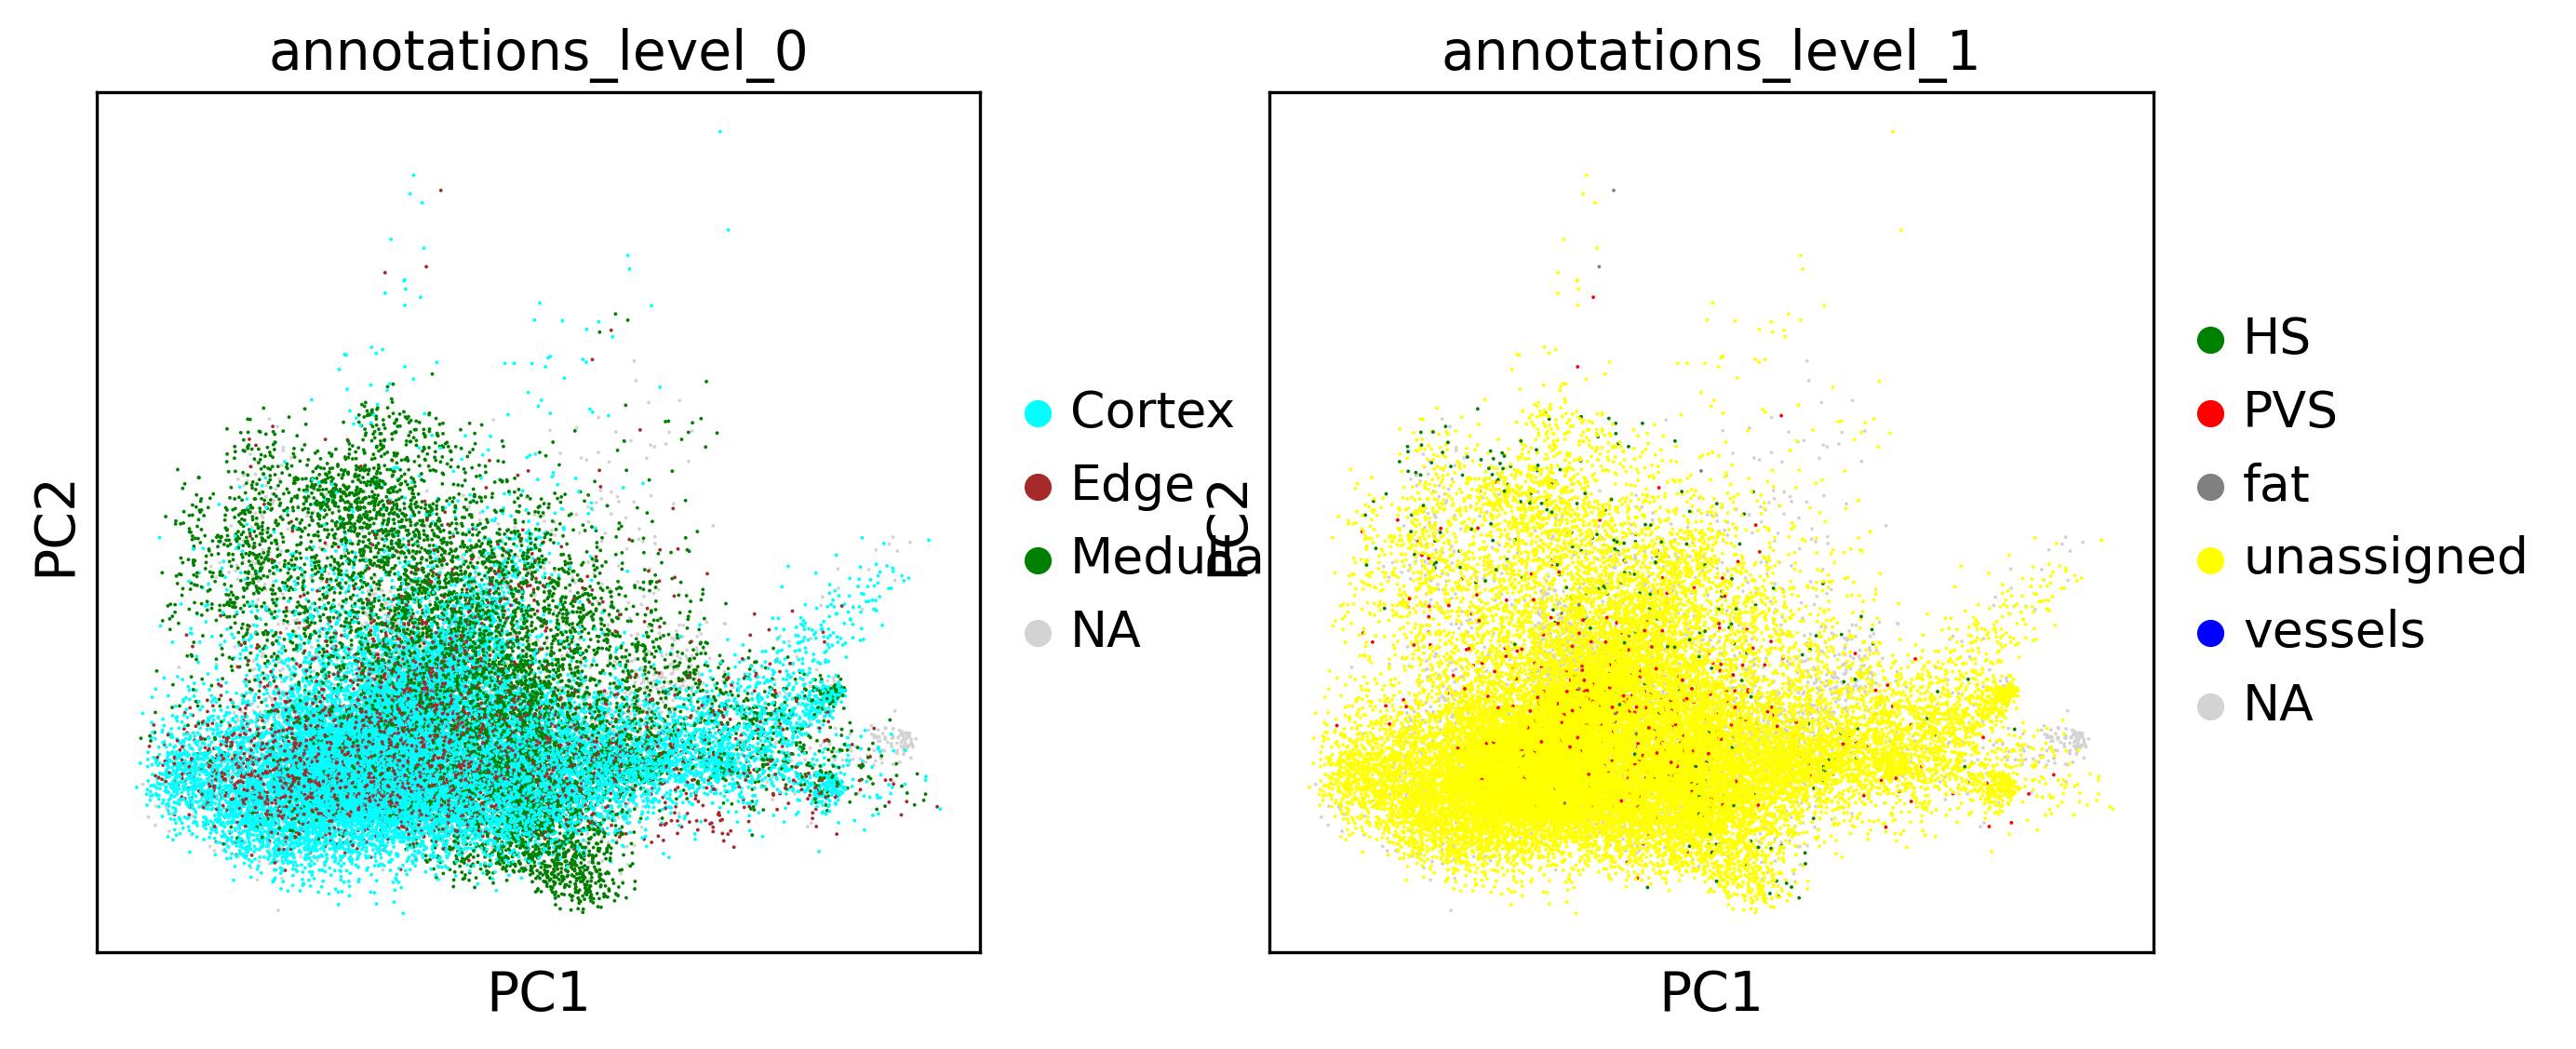

In [19]:
sc.pl.pca(adata_paed_full,color=['annotations_level_0','annotations_level_1'])

In [20]:
adata_paed_full

AnnData object with n_obs × n_vars = 35764 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'cma_v1', 'SampleID', 'Sample ', 'Sample_hr', 'SlideID', 'Position', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN/DV200', 'Spatial_type', 'DonorID', 'Donor_type', 'Age_group', 'Age(misc)', 'Age(numeric)', 'Source', 'Sex', 'QC', 'Batch', 'CMA version ', 'Spaceranger', 'Comments', 'Medians Genes per Spot (>1500)', 'Mean Reads per spot ', 'Median UMI per spot ', 'Usefull region out of tissue (>30%)', 'Tissue Morphology ', 'Spots under tissue', 'Fraction of reads in tissue', 'Sample Rank', 'original_image_name', 'old_sample_name', 'annotation_type', 'uploaded_annotated', 'annotated_path', '_indices', '_scvi_batch', '_scvi_labels', 'B(P)', 'B(Q)', 'B-stimulated', 'DC1', 'DC2', 'DC-Prolif', 'DC-a1', 

In [21]:
adata_paed_full.write_h5ad('adata_paed_full_v10.h5ad')